In [1]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [2]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20220924-234233_bc6ab27c1fbb472f54b9bcba56b7d233'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [3]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [5]:
example_id = 1

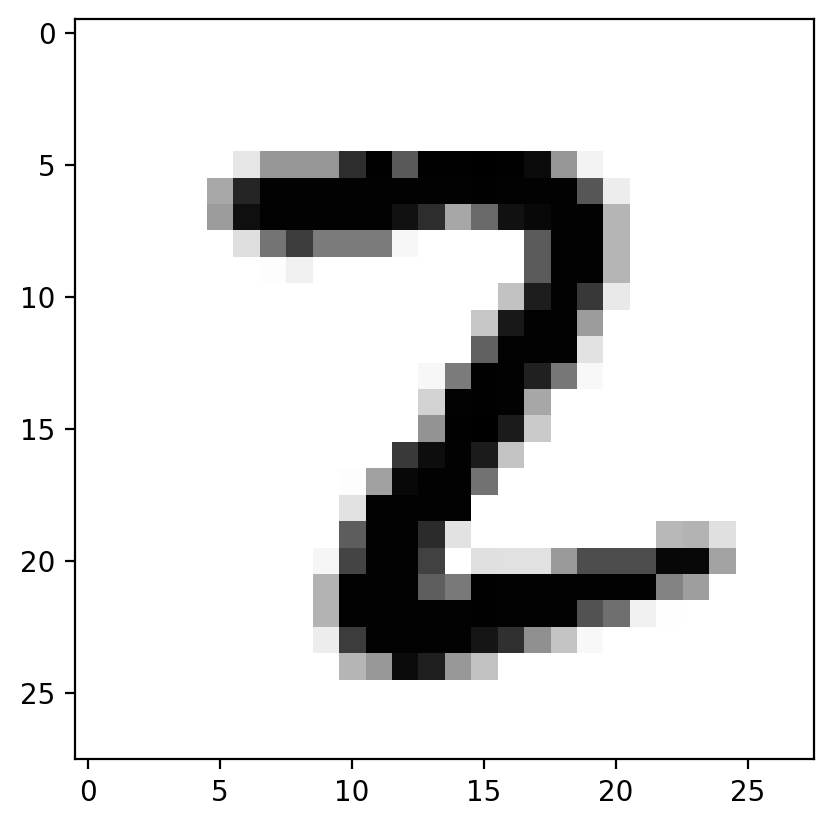

In [6]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

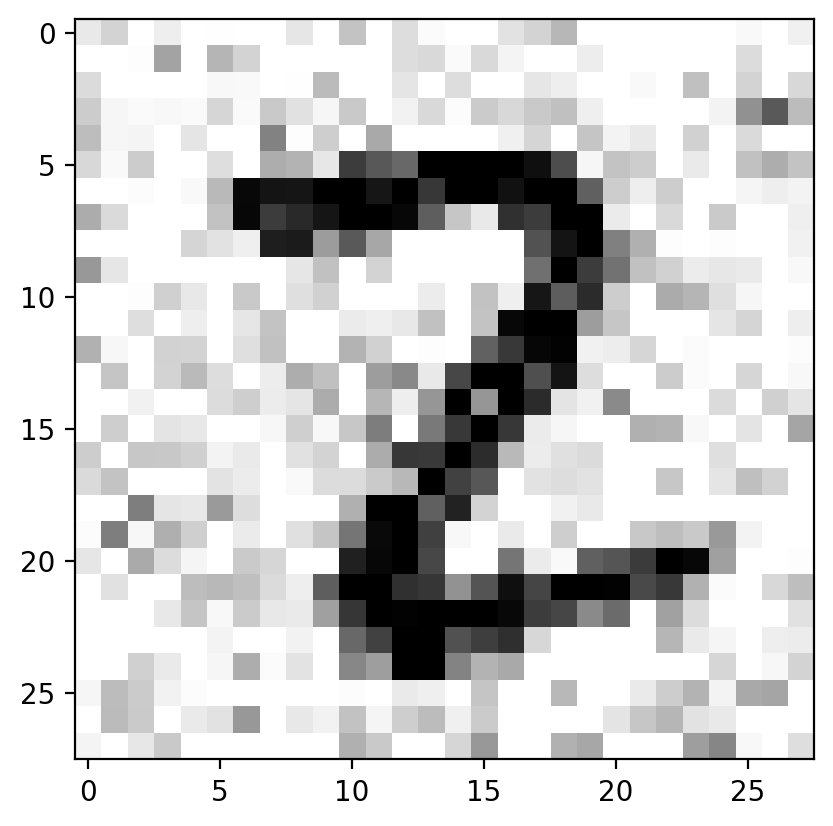

In [7]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [8]:
train_y.iloc[example_id]

digit    2
Name: 1, dtype: uint8

In [9]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

2022-10-02 21:58:03.988588: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-02 21:58:03.988651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-45-19): /proc/driver/nvidia/version does not exist


In [10]:
# In this couse, all assignments are expected to be
# implemented with Tensorflow framework.
# For this task, we can use its high-level Keras API:
# https://keras.io

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp: HyperParameters) -> tf.keras.Model:
    
    encoder_width = hp.Choice('encoder_width', values = [512, 256, 128, 64])
    activation_function = hp.Choice('activation_function', values = ["relu", "elu"])
    dropout_layer = hp.Boolean("dropout_layer")
    
    if dropout_layer:
    
        layers = [
            Dense(
                units=encoder_width, 
                activation=activation_function, 
                input_shape=(28 * 28,)
            ),
            Dropout(rate = 0.01),
            Dense(
                units=encoder_width/2, 
                activation=activation_function
            ),
            Dropout(rate = 0.01),
            Dense(
                units=encoder_width/4, 
                activation=activation_function
            ),
            Dropout(rate = 0.01),
            Dense(
                units=encoder_width/2, 
                activation=activation_function
            ),
            Dropout(rate = 0.01),
            Dense(
                units=encoder_width, 
                activation=activation_function
            ),
            Dropout(rate = 0.01),

            # Decoder: matches the shape of the image
            # Sigmoid activation is needed because pixel
            # values are real numbers between 0 (black) and 1 (white).
            Dense(units=28*28, activation='sigmoid')
        ]
    
    else:
        layers = [
            Dense(
                units=encoder_width, 
                activation=activation_function,
                input_shape=(28 * 28,)
            ),
            Dense(
                units=encoder_width/2, 
                activation=activation_function
            ),
            Dense(
                units=encoder_width/4, 
                activation=activation_function
            ),
            Dense(
                units=encoder_width/2, 
                activation=activation_function
            ),
            Dense(
                units=encoder_width, 
                activation=activation_function
            ),

            # Decoder: matches the shape of the image
            # Sigmoid activation is needed because pixel
            # values are real numbers between 0 (black) and 1 (white).
            Dense(units=28*28, activation='sigmoid')
        ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(
            lr=hp.Float(name='learning_rate', min_value=1e-5, max_value=1e0, sampling='log')
        ), 
        loss='mean_squared_error'
    )
    
    return autoencoder

/tmp/ipykernel_27562/1724091884.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [11]:
def train_model(model: tf.keras.Model, epochs: int) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X, 
        y=train_clean_X, 

        # It's a good idea to have low number of epochs,
        # to test the learning process, but not for the final model training.
        epochs=epochs,

        batch_size=128,
        shuffle=True,
        validation_data=(validate_noisy_X, validate_clean_X)
    )
    return history

In [12]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models
# without reseting the seed.

# import numpy as np
# import tensorflow as tf

# np.random.seed(11)
# tf.random.set_seed(11)

# hp = HyperParameters()
# hp.Fixed('encoder_width', value=100)
# hp.Fixed('learning_rate', value=1e-3)

# autoencoder = build_model(hp)
# history = train_model(autoencoder, epochs=1)

In [13]:
# The fit method returns a history object that
# can be used to plot the learning curve.

# learning_curve = pd.Series(history.history['loss'])
# learning_curve.index = learning_curve.index + 1

# learning_curve.plot(title='Learning Curve')
# plt.xticks(learning_curve.index)
# plt.show()

In [14]:
from kerastuner.tuners import RandomSearch

# A tuner implements a particular hyperoptimization strategy.
# This example uses a random search turner, which samples
# hyperparameter values from the distributions specified
# in the build_model function. You can use other tuners too:
# https://keras-team.github.io/keras-tuner/documentation/tuners/

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='denoiser_hyperop',
    overwrite=True,
    
    # Experiment name must change if you modify
    # the model structure or the set of hyperparameters.
    project_name='autoencoder_05'
)

# This displays which hyperparameters are tunable, and their respective distribution.
tuner.search_space_summary()

Search space summary
Default search space size: 4
encoder_width (Choice)
{'default': 512, 'conditions': [], 'values': [512, 256, 128, 64], 'ordered': True}
activation_function (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
dropout_layer (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


2022-10-02 21:58:04.334517: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
import numpy as np
import tensorflow as tf
np.random.seed(11)
tf.random.set_seed(11)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(    
    # All parameters here are passed thru to Model.fit function.
    x=train_noisy_X, 
    y=train_clean_X, 
    
    epochs=128,
    batch_size=128,
    shuffle=True,
    validation_data=(validate_noisy_X, validate_clean_X),
    callbacks=[stop_early]
)

Trial 10 Complete [00h 00m 45s]
val_loss: 0.1122234637538592

Best val_loss So Far: 0.00613902307425936
Total elapsed time: 01h 27m 36s
INFO:tensorflow:Oracle triggered exit


In [16]:
# The following function can be used to view the search summary.
tuner.results_summary()

Results summary
Results in denoiser_hyperop/autoencoder_05
Showing 10 best trials
Trial summary
Hyperparameters:
encoder_width: 512
activation_function: relu
dropout_layer: True
learning_rate: 0.0007172086325519386
Score: 0.00613902307425936
Trial summary
Hyperparameters:
encoder_width: 256
activation_function: elu
dropout_layer: True
learning_rate: 7.919153219962527e-05
Score: 0.006666922165701787
Trial summary
Hyperparameters:
encoder_width: 128
activation_function: elu
dropout_layer: True
learning_rate: 0.010077872683004542
Score: 0.01253359733770291
Trial summary
Hyperparameters:
encoder_width: 128
activation_function: relu
dropout_layer: False
learning_rate: 0.006511873080010123
Score: 0.014848302428921064
Trial summary
Hyperparameters:
encoder_width: 64
activation_function: relu
dropout_layer: True
learning_rate: 3.595584298931277e-05
Score: 0.022541687513391178
Trial summary
Hyperparameters:
encoder_width: 64
activation_function: elu
dropout_layer: False
learning_rate: 5.6907892

In [17]:
# The tuner's oracle property can be used to fetch information
# about every trial, which can be used to build a table like so.

pd.DataFrame([
    {
        'trial_id': t.trial_id,
        'score': t.score,
        **t.hyperparameters.values 
    }
    for t in tuner.oracle.get_best_trials(num_trials=10)
]).set_index('trial_id')

,score,encoder_width,activation_function,dropout_layer,learning_rate
trial_id,,,,,
02,0.006139,512,relu,True,0.000717
06,0.006667,256,elu,True,0.000079
01,0.012534,128,elu,True,0.010078
08,0.014848,128,relu,False,0.006512
03,0.022542,64,relu,True,0.000036
07,0.024579,64,elu,False,0.000057
05,0.030263,64,elu,True,0.000013
04,0.032927,64,elu,False,0.000012
00,0.111505,128,relu,False,0.115488


In [18]:
# This returns the best model found during the search.
autoencoder = tuner.get_best_models(num_models=1)[0]

/home/ec2-user/SageMaker/setup/miniconda/envs/ucla_deeplearning/lib/python3.10/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
# You can proceed with the above model, but it might 
# be also a good idea to do a final training pass with the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_hyperparameters.values
#autoencoder = build_model(best_hyperparameters)

{'encoder_width': 512,
 'activation_function': 'relu',
 'dropout_layer': True,
 'learning_rate': 0.0007172086325519386}

In [20]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

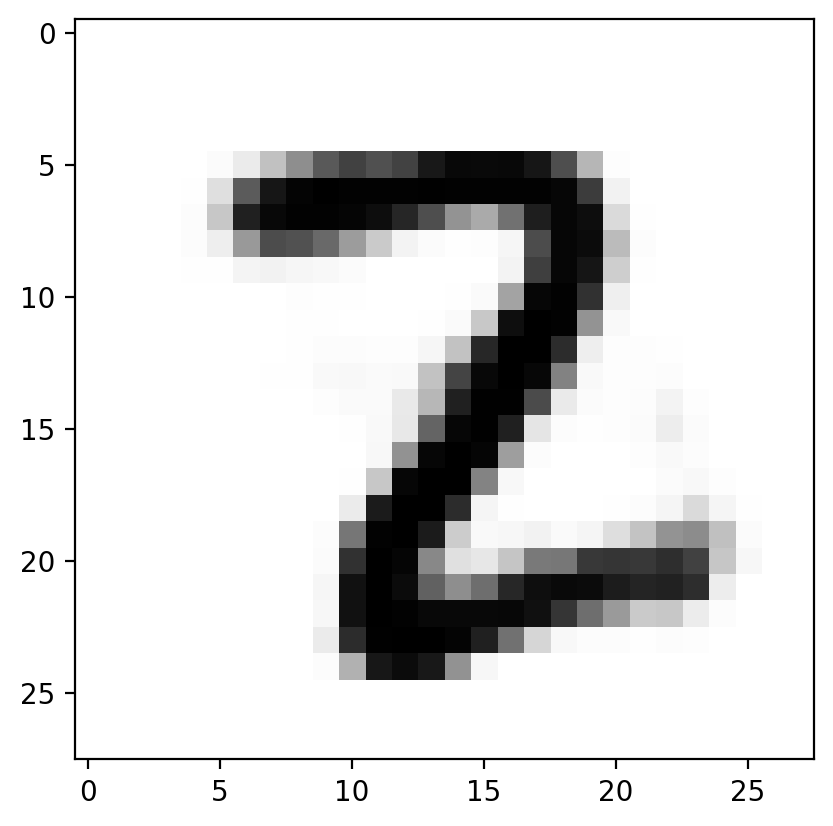

In [21]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [22]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.004490766

In [23]:
validate_denoised_X = autoencoder.predict(validate_noisy_X)
validate_denoised_X = pd.DataFrame(validate_denoised_X)
mean_squared_error(validate_denoised_X, validate_clean_X)

0.006118376

In [24]:
test_denoised_X = autoencoder.predict(test_noisy_X)
test_denoised_X = pd.DataFrame(test_denoised_X)
mean_squared_error(test_denoised_X, test_clean_X)

0.0062085027

In [25]:
import os 

model_dir = 'denoiser_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_dir}/score_denoised_x.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(autoencoder.to_json()), indent=True))

# Finally, let's save the learned parameters.
autoencoder.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.h5 -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset